In [46]:
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from torch.utils.data import TensorDataset

from two_spirals_utils import spiral_dataset, SpiralClassifier
from utils.utils import get_grid_predictions, create_contour_plot
from utils.attacks import fgsm, pgd

### Load pre-trained classifier model

In [47]:
classifier = SpiralClassifier(2, 2, n_inner_layers=4, width=128)
classifier.load_state_dict(torch.load("../data/models/classifier_two_spirals.pt"))
classifier.eval();

### Load "Two Spirals" dataset

In [48]:
# This cell would generate(!) new points from the two spirals distribution
n_samples   = 20_000
noise       = 3
n_rotations = 1.2

# Generate spiral dataset
# dataset = TensorDataset(*spiral_dataset(n_samples, noise, n_rotations))

In [49]:
# Instead of re-generating new points from the two spirals distribution all the
# time, we now create a fixed "Two Spirals" dataset and write it to disk.

# X, Y = spiral_dataset(n_samples, noise, n_rotations)
# dataset = { "X": X, "Y": Y }
# torch.save(dataset, "../data/two_spirals/spiral_dataset_20k.pt")

In [50]:
# Load the "Two Spirals" dataset from disk
loaded_dataset = torch.load("../data/two_spirals/spiral_dataset_20k.pt")

# Extract X and Y from the loaded dataset
X_loaded = loaded_dataset["X"]
Y_loaded = loaded_dataset["Y"]

dataset = TensorDataset(X_loaded, Y_loaded)

In [51]:
# Number of adversarial samples (not yet implemeted for numbers > 1)
n_adv_samples = 1

# How far the adversarial attack may shift the sample along any dimension
eps = 1e-1

# Pick an index from the following list of indices that have been found to
# succeed with eps = 1e-1 adversarial samples
# pick = 4
# idx  = [24, 12181, 12443, 12485, 12974, 13319, 15924, 16050, 16360, 19834][pick]

# Or pick an index at random
idx = int(torch.randint(n_samples, (n_adv_samples,)).item())

x = dataset.tensors[0][[idx]]
y = dataset.tensors[1][[idx]].item()

In [52]:
# Generate adversarial sample
x_adv = fgsm(classifier, x=x, label=y, eps=1e-1, targeted=False).detach().numpy()

In [53]:
with torch.no_grad():
    pred = classifier(torch.from_numpy(x_adv))
    pred = pred.argmax(axis=1).item()

print(f"Model classifies adversarial attack on sample {idx} as class {pred}.")
print(f"Correct class is {y}.")
print(f"Adversarial attack was {'SUCCESSFUL' if pred != y else 'UNSUCCESSFUL'}.")

Model classifies adversarial attack on sample 12167 as class 0.
Correct class is 1.
Adversarial attack was SUCCESSFUL.


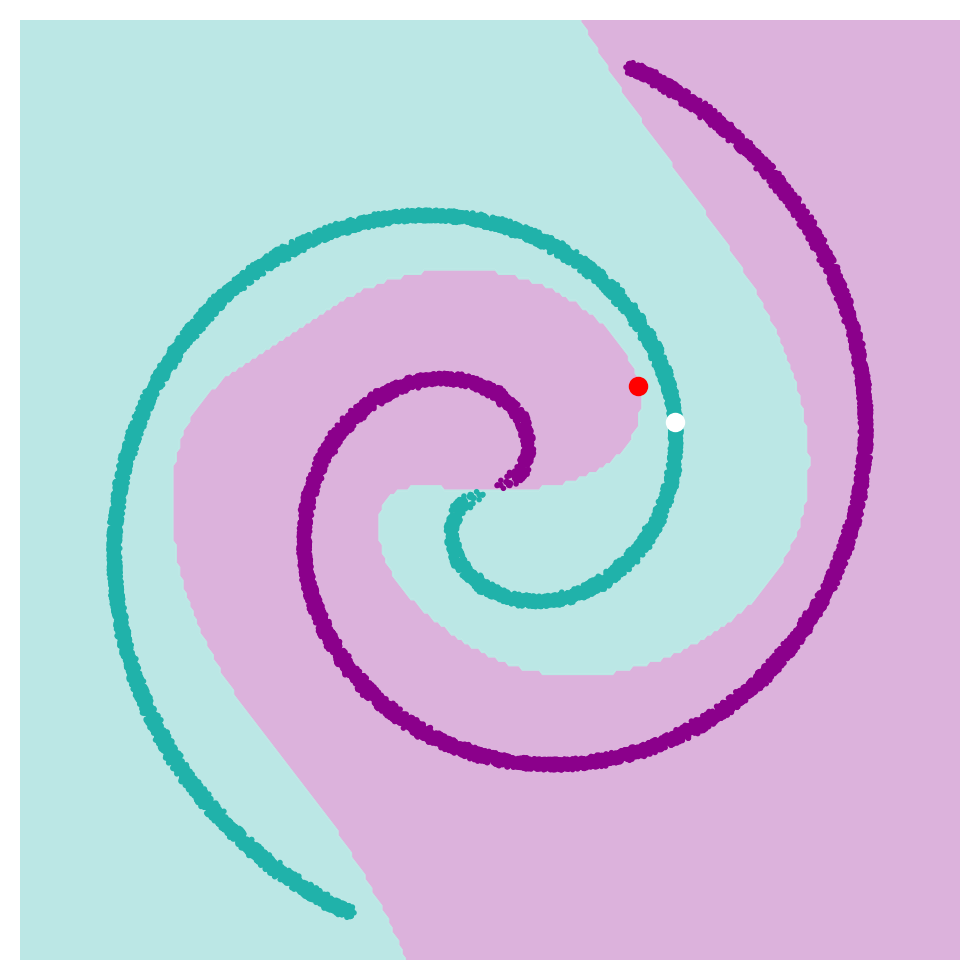

In [54]:
xs, ys, grid_preds = get_grid_predictions(classifier)
colormap = colors.ListedColormap(["darkmagenta", "lightseagreen"])
create_contour_plot(xs, ys, grid_preds, dataset=dataset, colormap=colormap)

plt.scatter(*x.T, c="white")
plt.scatter(*x_adv.T, c="red");